In [51]:
%cd C:\Users\123\Documents\Acad\TA_Inv\year18

C:\Users\123\Documents\Acad\TA_Inv\year18


In [1]:
%%html
<style>
.output_wrapper, .output {
    height:auto !important;
    max-height:10000px;  /* your desired max-height here */
}
.output_scroll {
    box-shadow:none !important;
    webkit-box-shadow:none !important;
}
</style>

In [2]:
#EXERCISE 2

In [233]:
import wrds
db=wrds.Connection(wrds_username='sevogel')
from datetime import datetime
db.create_pgpass_file()

Enter your WRDS username [sevogel]:sevogel
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [239]:
import numpy as np
import datetime

# get risk-free rate see http://www.crsp.com/files/treasury_guide_0.pdf
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1960-01-01'"
            "and mcaldt<='2019-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


# get stock index returns
data=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1960-01-01'"
            "and date<='2019-12-31'", date_cols=['date'])

# get bond data
bonds=db.raw_sql("select  caldt, b2ret, b10ret "
           "from crsp.mcti "           
            "where caldt>='1960-01-01'"
            "and caldt<='2019-12-31'", date_cols=['caldt'])
bonds=bonds.rename(columns={ "caldt": "date"})


In [240]:
import pandas as pd
riskfree= Rf["rf"].mean()

data = pd.merge(data,bonds, how='left', left_on=['date'],right_on='date')
data["mix"]=0.4*data["b2ret"]+0.6*data["vwretd"]
bonds_mean=data["b2ret"].mean()*12
bonds_vol=data["b2ret"].std()*np.sqrt(12)

stocks_mean=data["vwretd"].mean()*12
stocks_vol=data["vwretd"].std()*np.sqrt(12)

mix_mean=data["mix"].mean()*12
mix_vol=data["mix"].std()*np.sqrt(12)

data["rpul"]=(1/bonds_vol*data["b2ret"]+1/stocks_vol*data["vwretd"])/(1/bonds_vol+1/stocks_vol)
rpul_mean=data["rpul"].mean()*12
rpul_vol=data["rpul"].std()*np.sqrt(12)
k=mix_vol/rpul_vol
data["rp"]=k*data["rpul"]+(1-k)*riskfree

rp_mean=data["rp"].mean()*12
rp_vol=data["rp"].std()*np.sqrt(12)

bonds_sr=(bonds_mean-riskfree*12)/bonds_vol
stocks_sr=(stocks_mean-riskfree*12)/stocks_vol
mix_sr=(mix_mean-riskfree*12)/mix_vol
rpul_sr=(rpul_mean-riskfree*12)/rpul_vol
rp_sr=(rp_mean-riskfree*12)/rp_vol



In [241]:
SIGMA = data[["vwretd","b2ret"]].cov().values*12
INV_SIGMA = np.linalg.inv(SIGMA)

w_stocks=(INV_SIGMA@(np.array([stocks_mean-riskfree*12,bonds_mean-riskfree*12])))/(np.ones(2)@INV_SIGMA@(np.array([stocks_mean-riskfree*12,bonds_mean-riskfree*12])))   

data["tan"]=(w_stocks[1]*data["b2ret"]+w_stocks[0]*data["vwretd"])
tan_mean=data["tan"].mean()*12
tan_vol=data["tan"].std()*np.sqrt(12)
tan_sr=(tan_mean-riskfree*12)/tan_vol


MU= np.array([stocks_mean,bonds_mean,mix_mean,rp_mean,rpul_mean,tan_mean])
STD =np.array([stocks_vol,bonds_vol,mix_vol,rp_vol,rpul_vol,tan_vol])
SR =np.array([stocks_sr,bonds_sr,mix_sr,rp_sr,rpul_sr,tan_sr])

index = ['stocks', 'bonds', '60/20','RP','RPunlev','tangency']
pStats = pd.DataFrame({'mean' : MU, 
                    'volatiltiy' : STD,
                    'Sharpe' : SR
                      })
#pStats = pStats.reindex(['mean', 'volatility', 'sharpe ratio'])
#pStats = pStats.T
pStats.index  =index

print('\n  Mean, standard deviation and Sharpe ratio of portfolio returns:')
display(np.around(pStats,6))

covar = pd.DataFrame({'bonds' : [SIGMA[1,1],SIGMA[1,0]],
                      'stocks' : [SIGMA[1,0],SIGMA[0,0]]
                     })
covar.index  =['bonds','stocks']
print('\n  Covariance matrix:')
display(np.around(covar,6))
print("risk-free rate:", riskfree*12)


  Mean, standard deviation and Sharpe ratio of portfolio returns:


,Sharpe,mean,volatiltiy
stocks,0.418099,0.106528,0.150716
bonds,0.458133,0.056463,0.028266
60/20,0.469539,0.086811,0.092214
RP,0.594579,0.098342,0.092214
RPunlev,0.594579,0.064451,0.035214
tangency,0.595205,0.063736,0.033975



  Covariance matrix:


,bonds,stocks
bonds,0.000799,0.000401
stocks,0.000401,0.022715


risk-free rate: 0.043513489825433835



 (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:


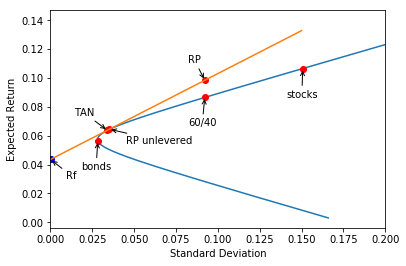

In [265]:
import matplotlib.pyplot as plt

#MV frontiers
Mup = np.linspace(0.003,0.14,1000)
MU = np.array([stocks_mean,bonds_mean])
ONES=np.ones(2)

A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)


MU1= np.array([stocks_mean,bonds_mean,mix_mean,rp_mean,rpul_mean,tan_mean])
STD1 =np.array([stocks_vol,bonds_vol,mix_vol,rp_vol,rpul_vol,tan_vol])

plt.plot(Sigmap,Mup)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(STD1,MU1,'ro')
plt.plot(0.0001,riskfree*12,'bo')
plt.xlim(0, 0.20)

plt.annotate('stocks', xy=(stocks_vol,stocks_mean), xytext=(stocks_vol-.01, stocks_mean-.02),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('bonds', xy=(bonds_vol,bonds_mean), xytext=(bonds_vol-.01, bonds_mean-.02),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP', xy=(rp_vol,rp_mean), xytext=(rp_vol-.01, rp_mean+.012),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP unlevered', xy=(rpul_vol,rpul_mean), xytext=(rpul_vol+.01, rpul_mean-.01),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('60/40', xy=(mix_vol,mix_mean), xytext=(mix_vol-.01, mix_mean-.02),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('TAN', xy=(tan_vol,tan_mean), xytext=(tan_vol-.02, tan_mean+.01),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('Rf', xy=(0, riskfree*12), xytext=(.001+.008, riskfree*12-.013),
            arrowprops=dict(arrowstyle="->")          
            )
sigma_values = np.linspace(0,0.15,100)

# first plot
efficient_line =riskfree*12+(tan_mean-riskfree*12)/tan_vol*sigma_values

plt.plot(sigma_values,efficient_line)

print('\n (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:')

plt.savefig('frontier1.png', format='png')
plt.show()


In [288]:
#first, download additional data to estimate standard deviations in the beginning of the sample

# get risk-free rate see http://www.crsp.com/files/treasury_guide_0.pdf
Rf=db.raw_sql("select  mcaldt,tmytm "
           "from crsp.tfz_mth_rf "           
            "where kytreasnox = 2000001 "
           "and mcaldt>='1957-01-01'"
            "and mcaldt<='2019-12-31'", date_cols=['mcaldt'])

#transform annualized and continuously compounded returns into simple and monthly returns:
Rf['tmytm']=np.exp(Rf['tmytm']/12/100)-1
Rf=Rf.rename(columns={ "mcaldt": "date","tmytm": "rf"})


# get stock index returns
data=db.raw_sql("select  date,vwretd "
           "from crsp.msi "
           "where date>='1957-01-01'"
            "and date<='2019-12-31'", date_cols=['date'])

# get bond data
bonds=db.raw_sql("select  caldt, b2ret, b10ret "
           "from crsp.mcti "           
            "where caldt>='1957-01-01'"
            "and caldt<='2019-12-31'", date_cols=['caldt'])
bonds=bonds.rename(columns={ "caldt": "date"})
data = pd.merge(data,bonds, how='left', left_on=['date'],right_on='date')


  Mean, standard deviation and Sharpe ratio of portfolio returns:


,Sharpe,mean,volatiltiy
stocks,0.418099,0.106528,0.150716
bonds,0.458133,0.056463,0.028266
60/20,0.469539,0.086811,0.092214
RP (rolling stdev),0.552784,0.094488,0.092214
RPunlev (rolling stdev),0.552784,0.062310,0.034003
tangency,0.595205,0.063736,0.033975



 (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:


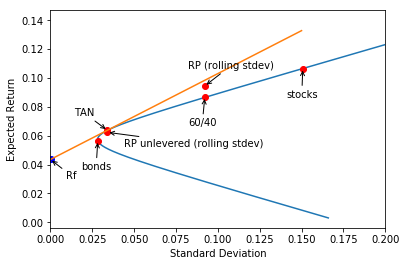

In [289]:
#compute rolling standard deviations
data['stocks_vol_rolling']=data['vwretd'].rolling(window=36, min_periods=3).std()
data['bonds_vol_rolling']=data['b2ret'].rolling(window=36, min_periods=3).std()

data=data[data['date']>='1960-01-01']
#compute portfolio returns etc
data["rpul_rolling"]=(1/data['bonds_vol_rolling']*data["b2ret"]+1/data['stocks_vol_rolling']*data["vwretd"])/(1/data['bonds_vol_rolling']+1/data['stocks_vol_rolling'])
rpul_rolling_mean=data["rpul_rolling"].mean()*12
rpul_rolling_vol=data["rpul_rolling"].std()*np.sqrt(12)
k_rolling=mix_vol/rpul_rolling_vol
data["rp_rolling"]=k_rolling*data["rpul_rolling"]+(1-k_rolling)*riskfree

rp_rolling_mean=data["rp_rolling"].mean()*12
rp_rolling_vol=data["rp_rolling"].std()*np.sqrt(12)

rpul_rolling_sr=(rpul_rolling_mean-riskfree*12)/rpul_rolling_vol
rp_rolling_sr=(rp_rolling_mean-riskfree*12)/rp_rolling_vol

# print table
MU= np.array([stocks_mean,bonds_mean,mix_mean,rp_rolling_mean,rpul_rolling_mean,tan_mean])
STD =np.array([stocks_vol,bonds_vol,mix_vol,rp_rolling_vol,rpul_rolling_vol,tan_vol])
SR =np.array([stocks_sr,bonds_sr,mix_sr,rp_rolling_sr,rpul_rolling_sr,tan_sr])

index = ['stocks', 'bonds', '60/20','RP (rolling stdev)','RPunlev (rolling stdev)','tangency']
pStats = pd.DataFrame({'mean' : MU, 
                    'volatiltiy' : STD,
                    'Sharpe' : SR
                      })
#pStats = pStats.reindex(['mean', 'volatility', 'sharpe ratio'])
#pStats = pStats.T
pStats.index  =index

print('\n  Mean, standard deviation and Sharpe ratio of portfolio returns:')
display(np.around(pStats,6))

#make plot
#MV frontiers
Mup = np.linspace(0.003,0.14,1000)
MU = np.array([stocks_mean,bonds_mean])
ONES=np.ones(2)

A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)


MU1= np.array([stocks_mean,bonds_mean,mix_mean,rp_rolling_mean,rpul_rolling_mean,tan_mean])
STD1 =np.array([stocks_vol,bonds_vol,mix_vol,rp_rolling_vol,rpul_rolling_vol,tan_vol])

plt.plot(Sigmap,Mup)
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.plot(STD1,MU1,'ro')
plt.plot(0.0001,riskfree*12,'bo')
plt.xlim(0, 0.20)

plt.annotate('stocks', xy=(stocks_vol,stocks_mean), xytext=(stocks_vol-.01, stocks_mean-.02),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('bonds', xy=(bonds_vol,bonds_mean), xytext=(bonds_vol-.01, bonds_mean-.02),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP (rolling stdev)', xy=(rp_rolling_vol,rp_rolling_mean), xytext=(rp_rolling_vol-.01, rp_rolling_mean+.012),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('RP unlevered (rolling stdev)', xy=(rpul_rolling_vol,rpul_rolling_mean), xytext=(rpul_rolling_vol+.01, rpul_rolling_mean-.01),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('60/40', xy=(mix_vol,mix_mean), xytext=(mix_vol-.01, mix_mean-.02),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('TAN', xy=(tan_vol,tan_mean), xytext=(tan_vol-.02, tan_mean+.01),
            arrowprops=dict(arrowstyle="->")
            )
plt.annotate('Rf', xy=(0, riskfree*12), xytext=(.001+.008, riskfree*12-.013),
            arrowprops=dict(arrowstyle="->")          
            )
sigma_values = np.linspace(0,0.15,100)

# first plot
efficient_line =riskfree*12+(tan_mean-riskfree*12)/tan_vol*sigma_values

plt.plot(sigma_values,efficient_line)

print('\n (d) Minimum-variance frontier and location of the 4 portfolios using ex-post performance:')
plt.savefig('frontier2.png', format='png')
plt.show()


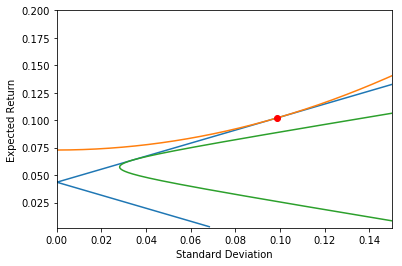


 (e) Optimal portfolio (with risk-free asset) of mean-variance optimizer:

 The portfolio weights are 
 [ 0.4184  2.4915]

 The portfolio expected return is 
 0.1021

 The portfolio volatility is 
 0.0989

 The investor borrows 1.9099 of what he invests in the tangency portfolio.


In [291]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

a=6

#MV frontier
Mup = np.linspace(0.003,0.14,1000)
MU = np.array([stocks_mean,bonds_mean])
ONES=np.ones(2)

A = (ONES@INV_SIGMA)@ONES
B = (ONES@INV_SIGMA)@MU
C = (MU@INV_SIGMA)@MU
DELTA = A*C-B**2

Sigmap = np.sqrt((A*np.multiply(Mup,Mup)-2*B*Mup+C)/DELTA)
    

mup = Mup
sigmap = Sigmap

w_opt = (1-B/a)/A*INV_SIGMA@ONES + 1/a*INV_SIGMA@MU
mu_opt = (1-B/a)/A*B + C/a
var_opt = (1-B/a)/A + mu_opt/a
sigma_opt = np.sqrt(var_opt)

Ustar = mu_opt-a/2*var_opt
sigmaIndiff = np.linspace(0,0.15,1000).reshape(1000,1)
muIndiff = Ustar+a/2*sigmaIndiff**2;

R = riskfree*12

sigmap_rf = np.abs(mup-R)/np.sqrt(C-2*R*B+A*R**2)
sigmap_rf = sigmap_rf.reshape(1000,1)

#optimal portfolio for particular risk aversion
w_opt = 1/a*INV_SIGMA@(MU-R)

mu_opt = R+(w_opt@(MU-R))
var_opt = (w_opt@SIGMA)@w_opt;
sigma_opt = np.sqrt(var_opt)
w_rf = 1-w_opt.sum()

#corresponding indifference curve
Ustar = mu_opt-a/2*var_opt
muIndiff = Ustar+a/2*sigmaIndiff**2

plt.plot(sigmap_rf,mup)
plt.plot(sigmaIndiff,muIndiff)
plt.plot(sigmap,mup)
plt.plot(sigma_opt,mu_opt,'ro')
plt.xlabel('Standard Deviation')
plt.ylabel('Expected Return')
plt.xlim(0, 0.15)
plt.ylim(0.002, 0.20)

plt.show()

print('\n (e) Optimal portfolio (with risk-free asset) of mean-variance optimizer:')
print('\n The portfolio weights are \n',np.around(w_opt,4))
print('\n The portfolio expected return is \n',np.around(mu_opt,4))
print('\n The portfolio volatility is \n',np.around(sigma_opt,4))
print('\n The investor borrows',np.around(w_opt.sum()-1,4),
      'of what he invests in the tangency portfolio.')



adsfasdf